In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from adjustText import adjust_text

In [3]:
# see columns
nfl.see_pbp_cols()

Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       ...
       'out_of_bounds', 'home_opening_kickoff', 'qb_epa', 'xyac_epa',
       'xyac_mean_yardage', 'xyac_median_yardage', 'xyac_success', 'xyac_fd',
       'xpass', 'pass_oe'],
      dtype='object', length=372)

In [4]:
# drop special teams plays
pbp = nfl.import_pbp_data([2022])
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])
# seeColls = pbp_rp.head()
# seeColls.to_clipboard()

2022 done.
Downcasting floats.


C:\Users\corla\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\nfl_data_py\__init__.py:137: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  plays.loc[:, cols] = plays.loc[:, cols].astype(numpy.float32)


In [5]:
# get pass epa stat df
pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'pass_epa'})
pass_epa.sort_values('pass_epa', ascending = False)
pass_epa.head()

,posteam,pass_epa
0,ARI,-0.079506
1,ATL,0.002979
2,BAL,-0.010278
3,BUF,0.162691
4,CAR,-0.063714


In [6]:
# get rush EPA and merge columns
rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby('posteam')['epa'].mean().reset_index().rename(columns = {'epa' : 'rush_epa'})
epa = pd.merge(pass_epa, rush_epa, on = 'posteam')
epa.head()

,posteam,pass_epa,rush_epa
0,ARI,-0.079506,-0.079682
1,ATL,0.002979,0.006186
2,BAL,-0.010278,0.015354
3,BUF,0.162691,-0.052620
4,CAR,-0.063714,-0.006957


In [7]:
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
logos.head()

,team_abbr,team_logo_espn
0,ARI,https://a.espncdn.com/i/teamlogos/nfl/500/ari.png
1,ATL,https://a.espncdn.com/i/teamlogos/nfl/500/atl.png
2,BAL,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png
3,BUF,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png
4,CAR,https://a.espncdn.com/i/teamlogos/nfl/500-dark...


Creating Logo Lists and their DFs

In [8]:
logo_paths = []
team_abbr = []
if not os.path.exists("logos"):
    os.makedirs("logos")

for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
logo_data = pd.DataFrame(data)

epa_with_logos = pd.merge(epa, logo_data, left_on = 'posteam', right_on = 'team_abbr')
epa_with_logos.head()

,posteam,pass_epa,rush_epa,team_abbr,logo_path
0,ARI,-0.079506,-0.079682,ARI,logos/ARI.tif
1,ATL,0.002979,0.006186,ATL,logos/ATL.tif
2,BAL,-0.010278,0.015354,BAL,logos/BAL.tif
3,BUF,0.162691,-0.052620,BUF,logos/BUF.tif
4,CAR,-0.063714,-0.006957,CAR,logos/CAR.tif


Adding the Visualization

Text(0.8, 0.005, 'Data: nflfastR')

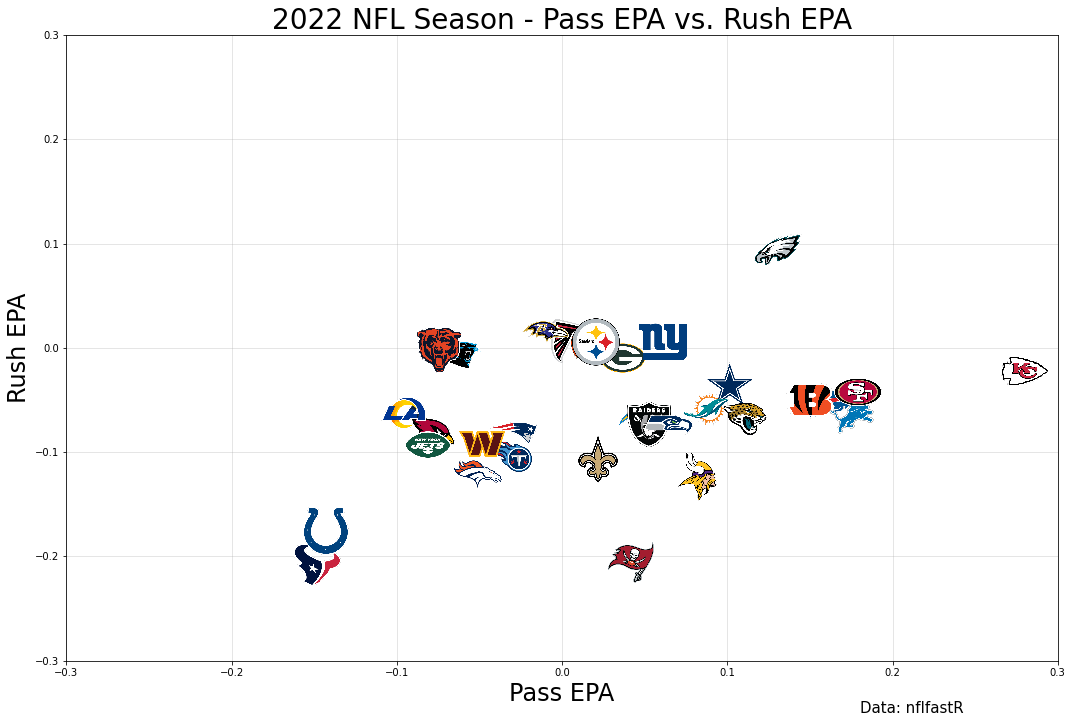

In [24]:
# Define a function for getting the image path and loading it into the visualization
def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

# Define plot size and autolayout
plt.rcParams["figure.figsize"] = [15, 10]
plt.rcParams["figure.autolayout"] = True

# Define the x and y variables
x = epa_with_logos['pass_epa']
y = epa_with_logos['rush_epa']

# Define the image paths
paths = epa_with_logos['logo_path']

# Define the plot
fig, ax = plt.subplots()

#Add grid
ax.grid(zorder=0,alpha=.4)
ax.set_axisbelow(True)

# Load the data into the plot
for x0, y0, path in zip(x, y, paths):
   ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
   ax.add_artist(ab)

# Plot parameters
plt.xlim(-0.3, 0.3);
plt.ylim(-0.3, 0.3);
plt.title("2022 NFL Season - Pass EPA vs. Rush EPA", fontdict={'fontsize':28});
plt.xlabel("Pass EPA", fontdict={'fontsize':24});
plt.ylabel("Rush EPA", fontdict={'fontsize':24});
plt.figtext(0.8, 0.005,'Data: nflfastR',fontsize=15)